<a href="https://colab.research.google.com/github/borislevant/cvplayground/blob/main/florence-2-tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install einops timm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
from unittest.mock import patch

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers.dynamic_module_utils import get_imports

def fixed_get_imports(filename):
    """Work around for https://huggingface.co/microsoft/phi-1_5/discussions/72."""
    if not str(filename).endswith("/modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
#!git clone https://github.com/borislevant/cvplayground

In [16]:
prompt = "<OD>"

#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"

#image = Image.open('cvplayground/imgs/car.jpg')
image = Image.open('drive/MyDrive/pictures/IMG_20200525_190012.jpg').transpose(Image.ROTATE_270)

inputs = processor(text=prompt, images=image, return_tensors="pt")
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.width, image.height))

print(parsed_answer)

{'<OD>': {'bboxes': [[1270.5, 3474.0, 1816.5, 3862.0], [1264.5, 3518.0, 1546.5, 3862.0], [1510.5, 3474.0, 1825.5, 3766.0], [772.5, 3522.0, 1039.5, 3870.0], [1045.5, 3406.0, 1279.5, 3734.0], [502.5, 666.0, 1804.5, 3862.0], [1222.5, 874.0, 1600.5, 1282.0], [1384.5, 1770.0, 1711.5, 2062.0], [502.5, 2050.0, 1375.5, 3146.0], [1252.5, 1454.0, 2008.5, 3858.0], [1270.5, 3518.0, 1534.5, 3854.0], [1516.5, 3474.0, 1819.5, 3754.0], [790.5, 3530.0, 1030.5, 3870.0], [1057.5, 3414.0, 1270.5, 3726.0], [1270.5, 2838.0, 1843.5, 3622.0]], 'labels': ['footwear', 'footwear', 'footwear', 'footwear', 'footwear', 'girl', 'human face', 'human face', 'miniskirt', 'person', 'sneakers', 'sneakers', 'sneakers', 'sneakers', 'trousers']}}


In [33]:
import matplotlib.pyplot as plt
from PIL import ImageDraw
import matplotlib.patches as patches
from textwrap import wrap
import os
import glob

def display_bounding_boxes(image, boxes, predictions):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Iterate over the boxes and predictions
    for box, prediction in zip(boxes, predictions):
        # Extract the coordinates of the box
        x, y, w, h = box

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')

        # Add the rectangle patch to the axes
        ax.add_patch(rect)

        # Add the prediction text above the bounding box
        ax.text(x, y-10, prediction, color='g', fontsize=12)

    # Show the plot with bounding boxes and predictions
    plt.show()

# Display the image with bounding boxes and predictions
#display_bounding_boxes(image, parsed_answer[prompt]['bboxes'], parsed_answer[prompt]['labels'])


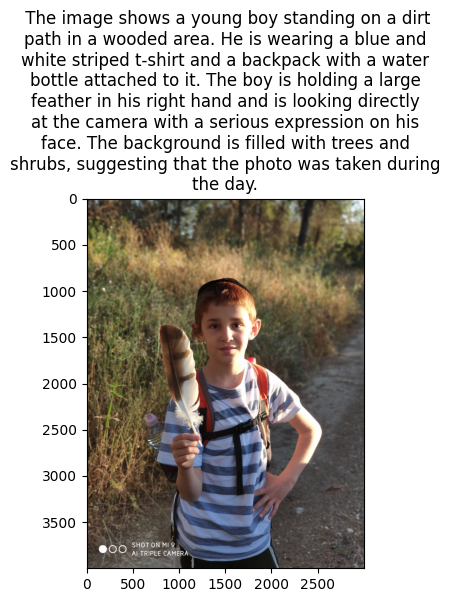

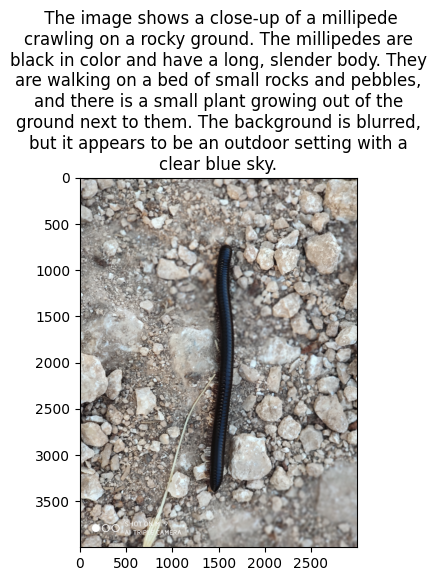

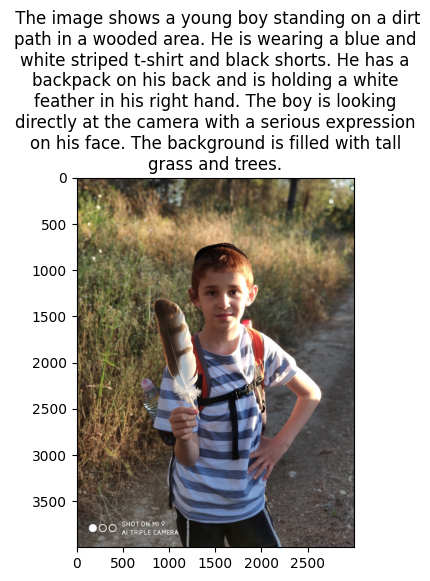

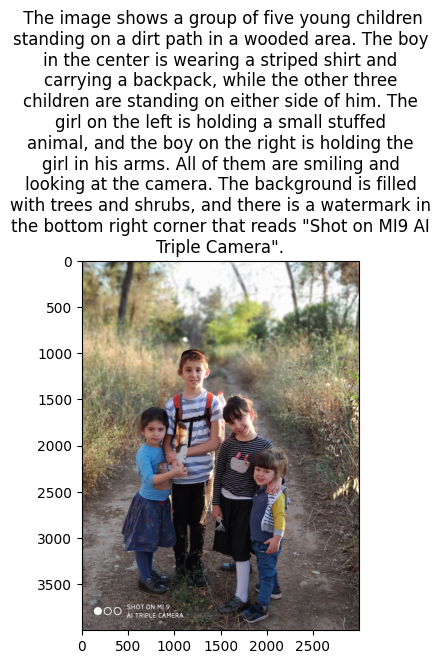

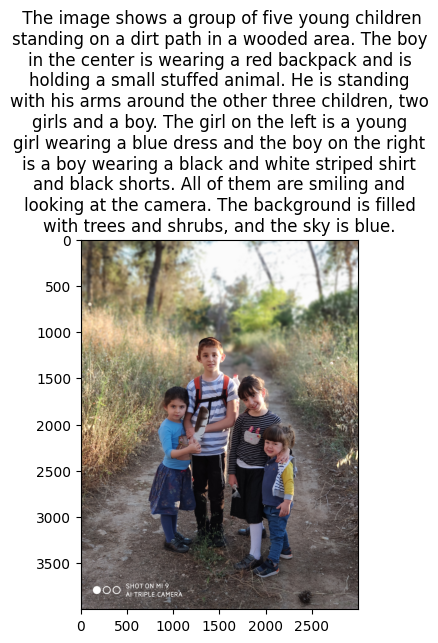

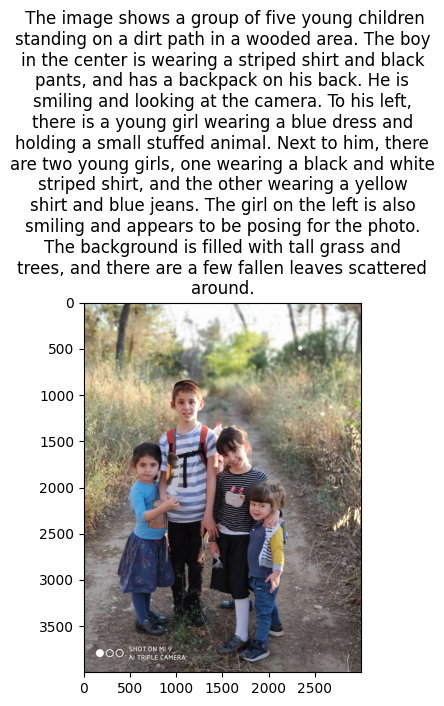

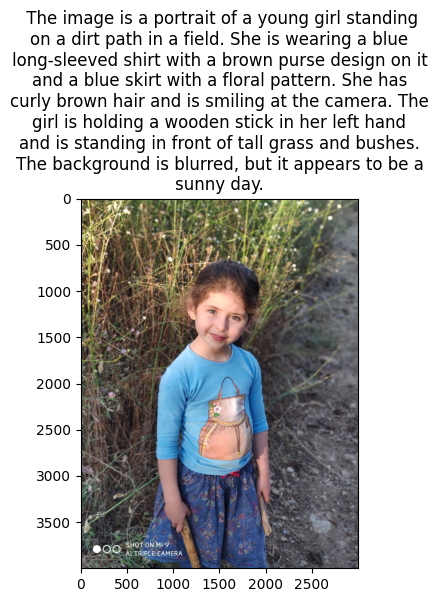

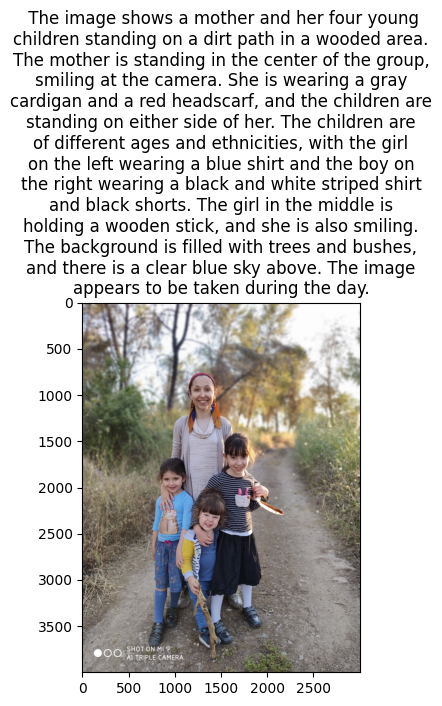

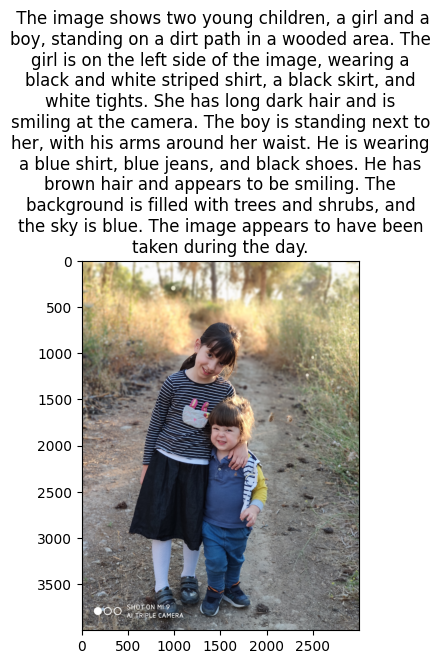

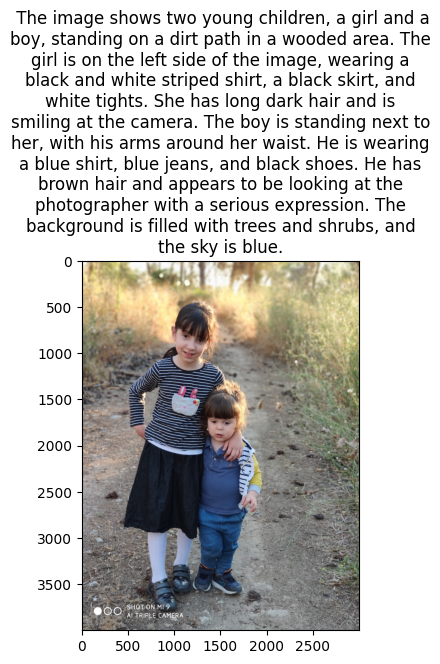

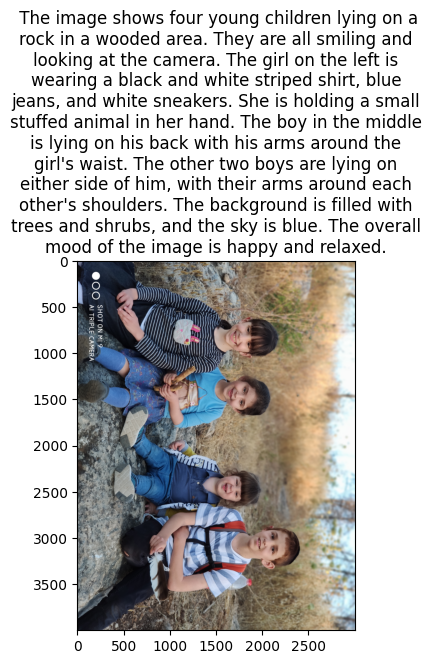

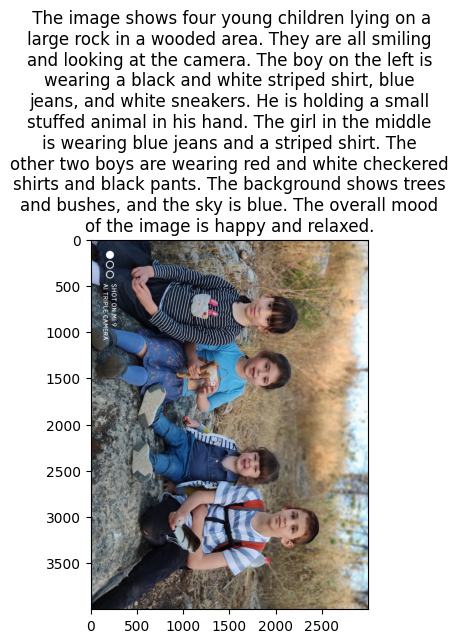

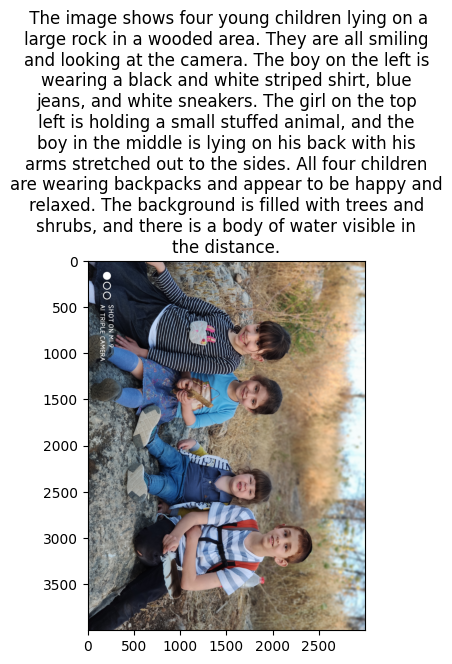

In [ ]:
prompt = '<MORE_DETAILED_CAPTION>'
image_list = glob.glob('drive/MyDrive/pictures' + "/*.jpg")

def display_image(img, desc):
    wrapped_description = '\n'.join(wrap(parsed_answer[prompt], 50))
    plt.imshow(image)
    plt.title(wrapped_description)
    plt.show()

for image_path in image_list:
    image = Image.open(image_path).transpose(Image.ROTATE_270)

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3,
        do_sample=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.width, image.height))
    display_image(image, parsed_answer[prompt])


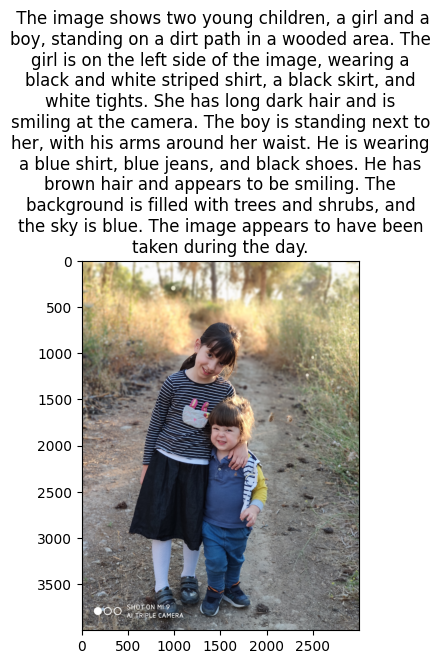

In [28]:
wrapped_description = '\n'.join(wrap(parsed_answer[prompt], 50))

plt.imshow(image)
plt.title(wrapped_description)
plt.show()